In [5]:
import os

import torch
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')

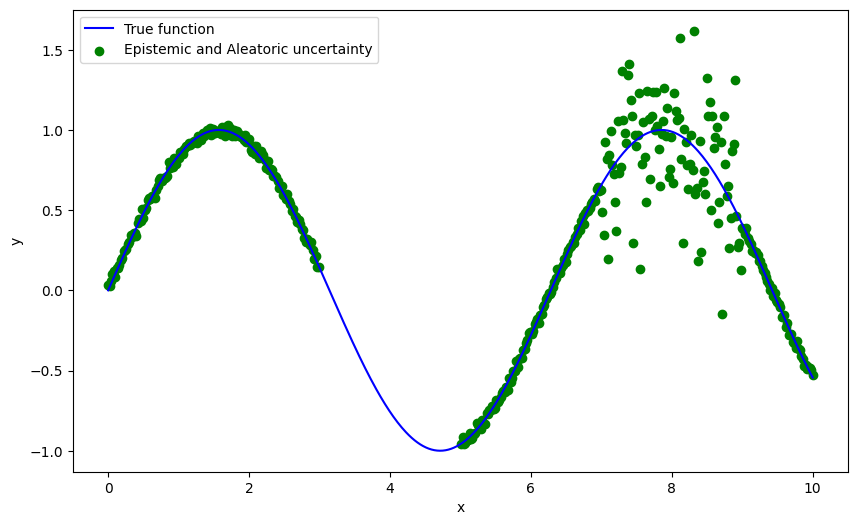

In [12]:
# Define the true function
def true_function(x):
    return np.sin(x)

# Generate data
np.random.seed(0)
x = np.linspace(0, 10, 500)  # Increase the number of points
y = true_function(x)

# Introduce epistemic uncertainty by removing some data points
epistemic_range = (3, 5)  # Define the range where data points are removed
mask = (x < epistemic_range[0]) | (x > epistemic_range[1])
x_epistemic = x[mask]
y_epistemic = y[mask] + np.random.normal(0, 0.02, size=y[mask].shape)

# Introduce aleatoric uncertainty by replacing noise in some data points
aleatoric_range = (7, 9)  # Define the range where noise is added
aleatoric_mask = (x_epistemic >= aleatoric_range[0]) & (x_epistemic <= aleatoric_range[1])
y_epistemic[aleatoric_mask] = true_function(x_epistemic[aleatoric_mask]) + np.random.normal(0, 0.3, size=y_epistemic[aleatoric_mask].shape)

# Plot the true function and the data samples
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='True function', color='blue')
plt.scatter(x_epistemic, y_epistemic, label='Epistemic and Aleatoric uncertainty', color='green')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


In [19]:
x_tensor = torch.from_numpy(x_epistemic).float().unsqueeze(1)
y_tensor = torch.from_numpy(y_epistemic).float().unsqueeze(1)

# Create a simple dataset
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.len = len(x)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

dataset = CustomDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Print information about the dataset
print("Dataset length:", len(dataset))
print("First element of dataset:", dataset[0])

# Example of iterating through the dataloader
for batch_idx, (data, target) in enumerate(dataloader):
    print("Batch index:", batch_idx)
    print("Data shape:", data.shape)
    print("Target shape:", target.shape)
    break

Dataset length: 400
First element of dataset: (tensor([0.]), tensor([0.0353]))
Batch index: 0
Data shape: torch.Size([8, 1])
Target shape: torch.Size([8, 1])


In [ ]:
import pytorch_lightning as pl
from torch.optim import Adam
from bayesian_torch.layers import LinearFlipout, LinearReparameterization

import torch.nn as nn
import torch.nn.functional as F

class MLP(pl.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, learning_rate=1e-3):
        super().__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.SiLU()
        )
        self.last_layer_1 = nn.Linear(hidden_size, hidden_size)
        self.last_layer_2 = nn.Linear(hidden_size, output_size)
        self.learning_rate = learning_rate
        self.bnn = False

    def forward(self, x):
        x = self.hidden_layers(x)
        x = F.silu(self.last_layer_1(x))
        return self.last_layer_2(x)
    
    def forward_bnn(self, x):
        x = self.hidden_layers(x)
        x, kl_1 = self.last_layer_1(x)
        x = F.silu(x)
        x, kl_2 = self.last_layer_2(x)
        return x, kl_1 + kl_2

    def training_step(self, batch, batch_idx):
        x, y = batch
        
        if not self.bnn:
            y_hat = self(x)
            loss = F.mse_loss(y_hat, y)
            self.log('train_loss', loss)
            return loss
        else:
            outs = []
            kls = []
            for _ in range(5):
                out, kl = self.forward_bnn(x)
                outs.append(y_hat)
                kls.append(kl)
                
            outs = torch.stack(outs)
            kls = torch.stack(kls)
            y_hat = outs.mean(dim=0)
            kl = kls.mean()
            var = outs.var(dim=0)
            
            loss = (F.mse_loss(y_hat, y)) + kl/x.shape[0]
            self.log('train_loss', loss)
            return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def to_bnn(self):
        hidden_size = self.last_layer_1.in_features
        intermediate_size = self.last_layer_1.out_features
        output_size = self.last_layer_2.out_features
        self.last_layer_1 = LinearReparameterization(hidden_size, intermediate_size)
        self.last_layer_2 = LinearReparameterization(intermediate_size, output_size)
        self.bnn = True


In [81]:

# Model parameters
INPUT_SIZE = 1
HIDDEN_SIZE = 128
OUTPUT_SIZE = 1
LEARNING_RATE = 1e-4
NUM_EPOCHS = 200

# Initialize the model
model = MLP(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, LEARNING_RATE)

# Initialize the Trainer
trainer = pl.Trainer(max_epochs=NUM_EPOCHS)

# Train the model
trainer.fit(model, dataloader)

/media/ssd/Programming/truthful_counterfactuals/venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /media/ssd/Programming/truthful_counterfactuals/venv ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params | Mode 
-----------------------------------------------------
0 | hidden_layers | Sequential | 16.8 K | train
1 | last_layer_1  | Linear     | 16.5 K | train
2 | last_layer_2  | Linear     | 129    | train
-----------------------------------------------------
33.4 K    Trainable params
0         Non-trainable params
33.4 K    Total params
0.134     Total estimated model params size (MB)
7         Modules in train mode
0        

Epoch 199: 100%|██████████| 50/50 [00:00<00:00, 367.99it/s, v_num=16]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 50/50 [00:00<00:00, 355.91it/s, v_num=16]


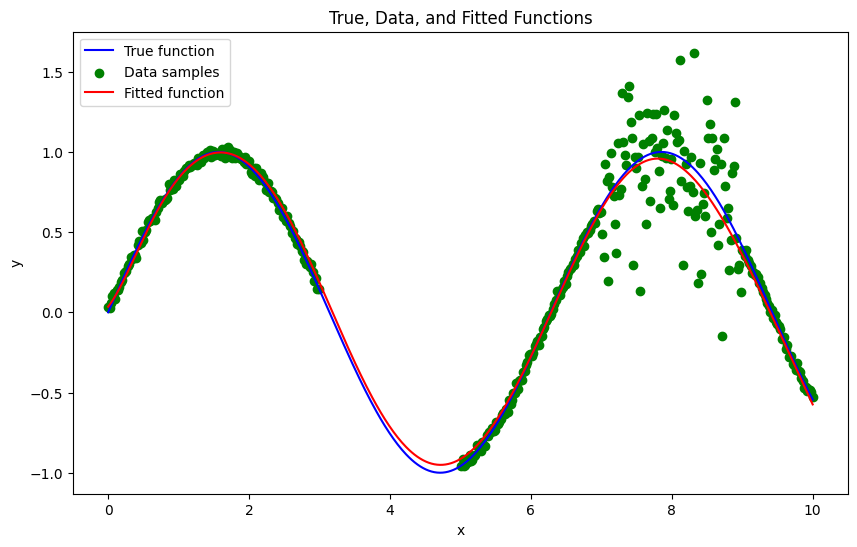

In [82]:
# Ensure the model is in evaluation mode
model.eval()

# Generate predictions from the model
x_new = np.linspace(0, 10, 500)
x_tensor_new = torch.from_numpy(x_new).float().unsqueeze(1)

with torch.no_grad():
    predicted_tensor = model(x_tensor_new)
    predicted = predicted_tensor.numpy()

# Plot the true function, data samples, and the fitted function
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='True function', color='blue')
plt.scatter(x_epistemic, y_epistemic, label='Data samples', color='green')
plt.plot(x_new, predicted, label='Fitted function', color='red')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('True, Data, and Fitted Functions')
plt.show()

In [83]:
model.train()
model.to_bnn()

# Train the model
trainer = pl.Trainer(max_epochs=100)
trainer.fit(model, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                     | Params | Mode 
-------------------------------------------------------------------
0 | hidden_layers | Sequential               | 16.8 K | train
1 | last_layer_1  | LinearReparameterization | 33.0 K | train
2 | last_layer_2  | LinearReparameterization | 258    | train
-------------------------------------------------------------------
50.1 K    Trainable params
0         Non-trainable params
50.1 K    Total params
0.200     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 50/50 [00:00<00:00, 215.08it/s, v_num=17]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 50/50 [00:00<00:00, 209.79it/s, v_num=17]


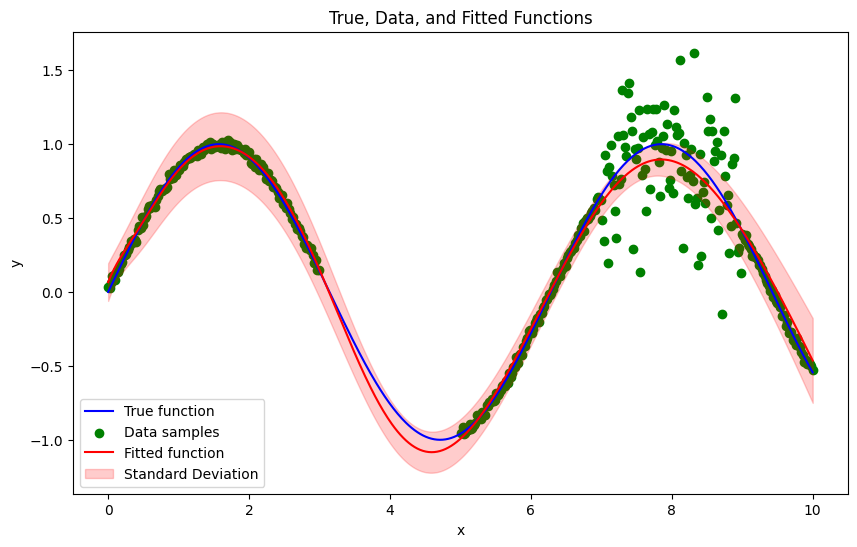

In [86]:
from bayesian_torch.utils.util import predictive_entropy, mutual_information

# Generate predictions from the model
# Generate predictions from the model
x_new = np.linspace(0, 10, 500)
x_tensor_new = torch.from_numpy(x_new).float().unsqueeze(1)

NUM_MC_RUNS = 5

model.eval()
with torch.no_grad():
    output = []
    for _ in range(NUM_MC_RUNS):
        predicted_tensor, predicted_kl = model.forward_bnn(x_tensor_new)
        output.append(predicted_tensor.numpy())
    
    output = np.stack(output, axis=0)
    mean = np.mean(output, axis=0)
    std = np.std(output, axis=0)
    #std = predictive_entropy(output)
    #std = mutual_information(output)
    # mean = np.expand_dims(mean, axis=-1)
    #std = np.expand_dims(std, axis=-1)

# Plot the true function, data samples, and the fitted function
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='True function', color='blue')
plt.scatter(x_epistemic, y_epistemic, label='Data samples', color='green')
plt.plot(x_new, mean, label='Fitted function', color='red')
plt.fill_between(x_new, mean[:, 0] - std[:, 0], mean[:, 0] + std[:, 0], color='red', alpha=0.2, label='Standard Deviation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('True, Data, and Fitted Functions')
plt.show()